In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df_female_act = pd.read_csv('data/mouse_fem_act.csv')
df_male_act = pd.read_csv('data/mouse_male_act.csv')
df_female_temp = pd.read_csv('data/mouse_fem_temp.csv')
df_male_temp = pd.read_csv('data/mouse_male_temp.csv')

In [3]:
df_female = df_female_act.merge(df_female_temp, left_index=True, right_index=True, suffixes=('_act','_temp'))
df_male = df_male_act.merge(df_male_temp, left_index=True, right_index=True, suffixes=('_act','_temp'))

In [4]:
df_female.duplicated().sum(),df_male.duplicated().sum()

(np.int64(0), np.int64(0))

In [5]:
df_female.isnull().sum().sum(),df_male.isnull().sum().sum()

(np.int64(0), np.int64(0))

In [6]:
df_female = df_female.set_index('time')
df_male = df_male.set_index('time')
df_female.index = df_female.index / 60
df_male.index = df_male.index / 60

df_female = df_female.groupby(df_female.index.astype(int)).mean().reset_index()
df_male = df_male.groupby(df_male.index.astype(int)).mean().reset_index()

In [7]:
# create date and hour column
df_female['day'] = df_female['time'] // 24 + 1
df_female['hour'] = df_female['time'] % 24
df_male['day'] = df_male['time'] // 24 + 1
df_male['hour'] = df_male['time'] % 24

# check if it's night
df_female['is_night'] = (df_female['hour'] // 12).astype(bool)
df_male['is_night'] = (df_male['hour'] // 12).astype(bool)

# check the estrus of female
df_female['is_estrus'] = ~((df_female['day'] - 2) % 4).astype(bool)

# while male don't have estrus, display it for male as well
df_male['is_estrus'] = ~((df_male['day'] - 2) % 4).astype(bool)

In [9]:
mouse_act_df = df_male.merge(df_female)
mouse_act_df['estrus_night'] = mouse_act_df['is_estrus'].astype(str) + '_' + mouse_act_df['is_night'].astype(str)

ohe = OneHotEncoder(sparse_output=False)
# Apply OneHotEncoder to the combined variable
encoded_columns = ohe.fit_transform(mouse_act_df[['estrus_night']])
mouse_act_df[ohe.get_feature_names_out()] = encoded_columns
mouse_act_df.to_csv('mouse.csv', index=False)

- time: Minute-level timestamp, sequentially ordered from the start of the experiment.
- day: Experimental day (1–14), representing the full duration of the study.
- hour: Hour of the day (0–23), indicating the time within a 24-hour cycle.
- is_night: Boolean indicator (1 = night, 0 = day), denoting whether the light cycle is in the dark phase (mice are nocturnal and more active during this period).
- is_estrus: Boolean indicator (1 = estrus, 0 = non-estrus), marking the estrus phase in female mice, which occurs every 4 days starting from day 2.
- m1_act – m13_act: Activity level of male mice (IDs 1–13), recorded as a float value per minute.
- f1_act – f13_act: Activity level of female mice (IDs 1–13), recorded as a float value per minute.
- m1_temp – m13_temp: Core body temperature of male mice (IDs 1–13), recorded in degrees Celsius (°C) per minute.
- f1_temp – f13_temp: Core body temperature of female mice (IDs 1–13), recorded in degrees Celsius (°C) per minute.
- estrus_night: Followed by OneHotEncoded columns

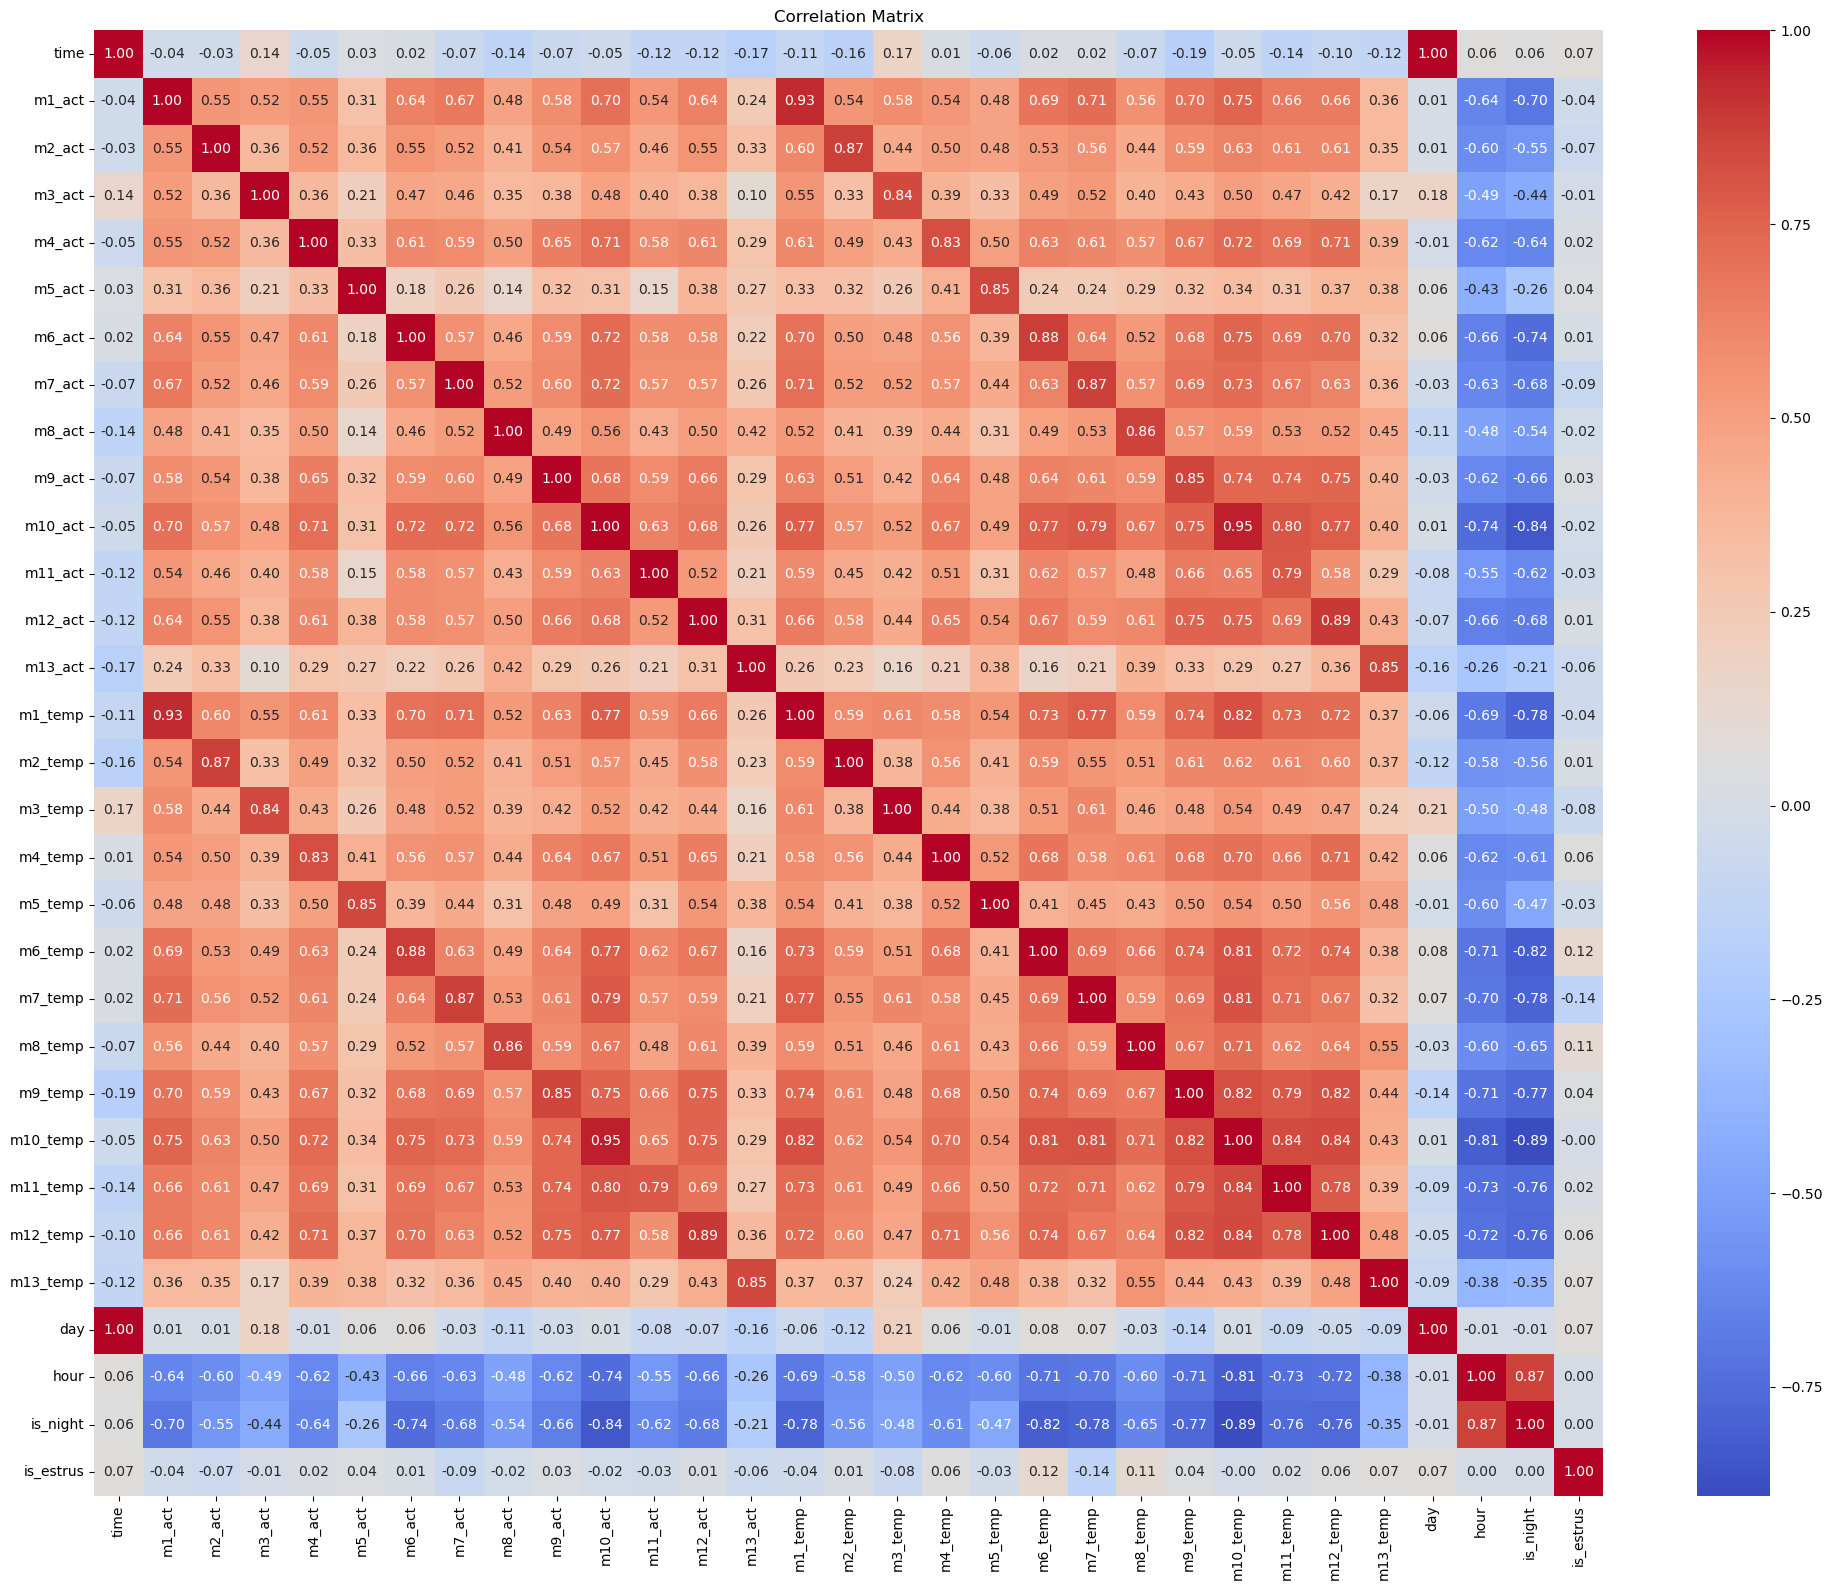

In [11]:
correlation_matrix = df_male.corr()
plt.figure(figsize=(20,16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

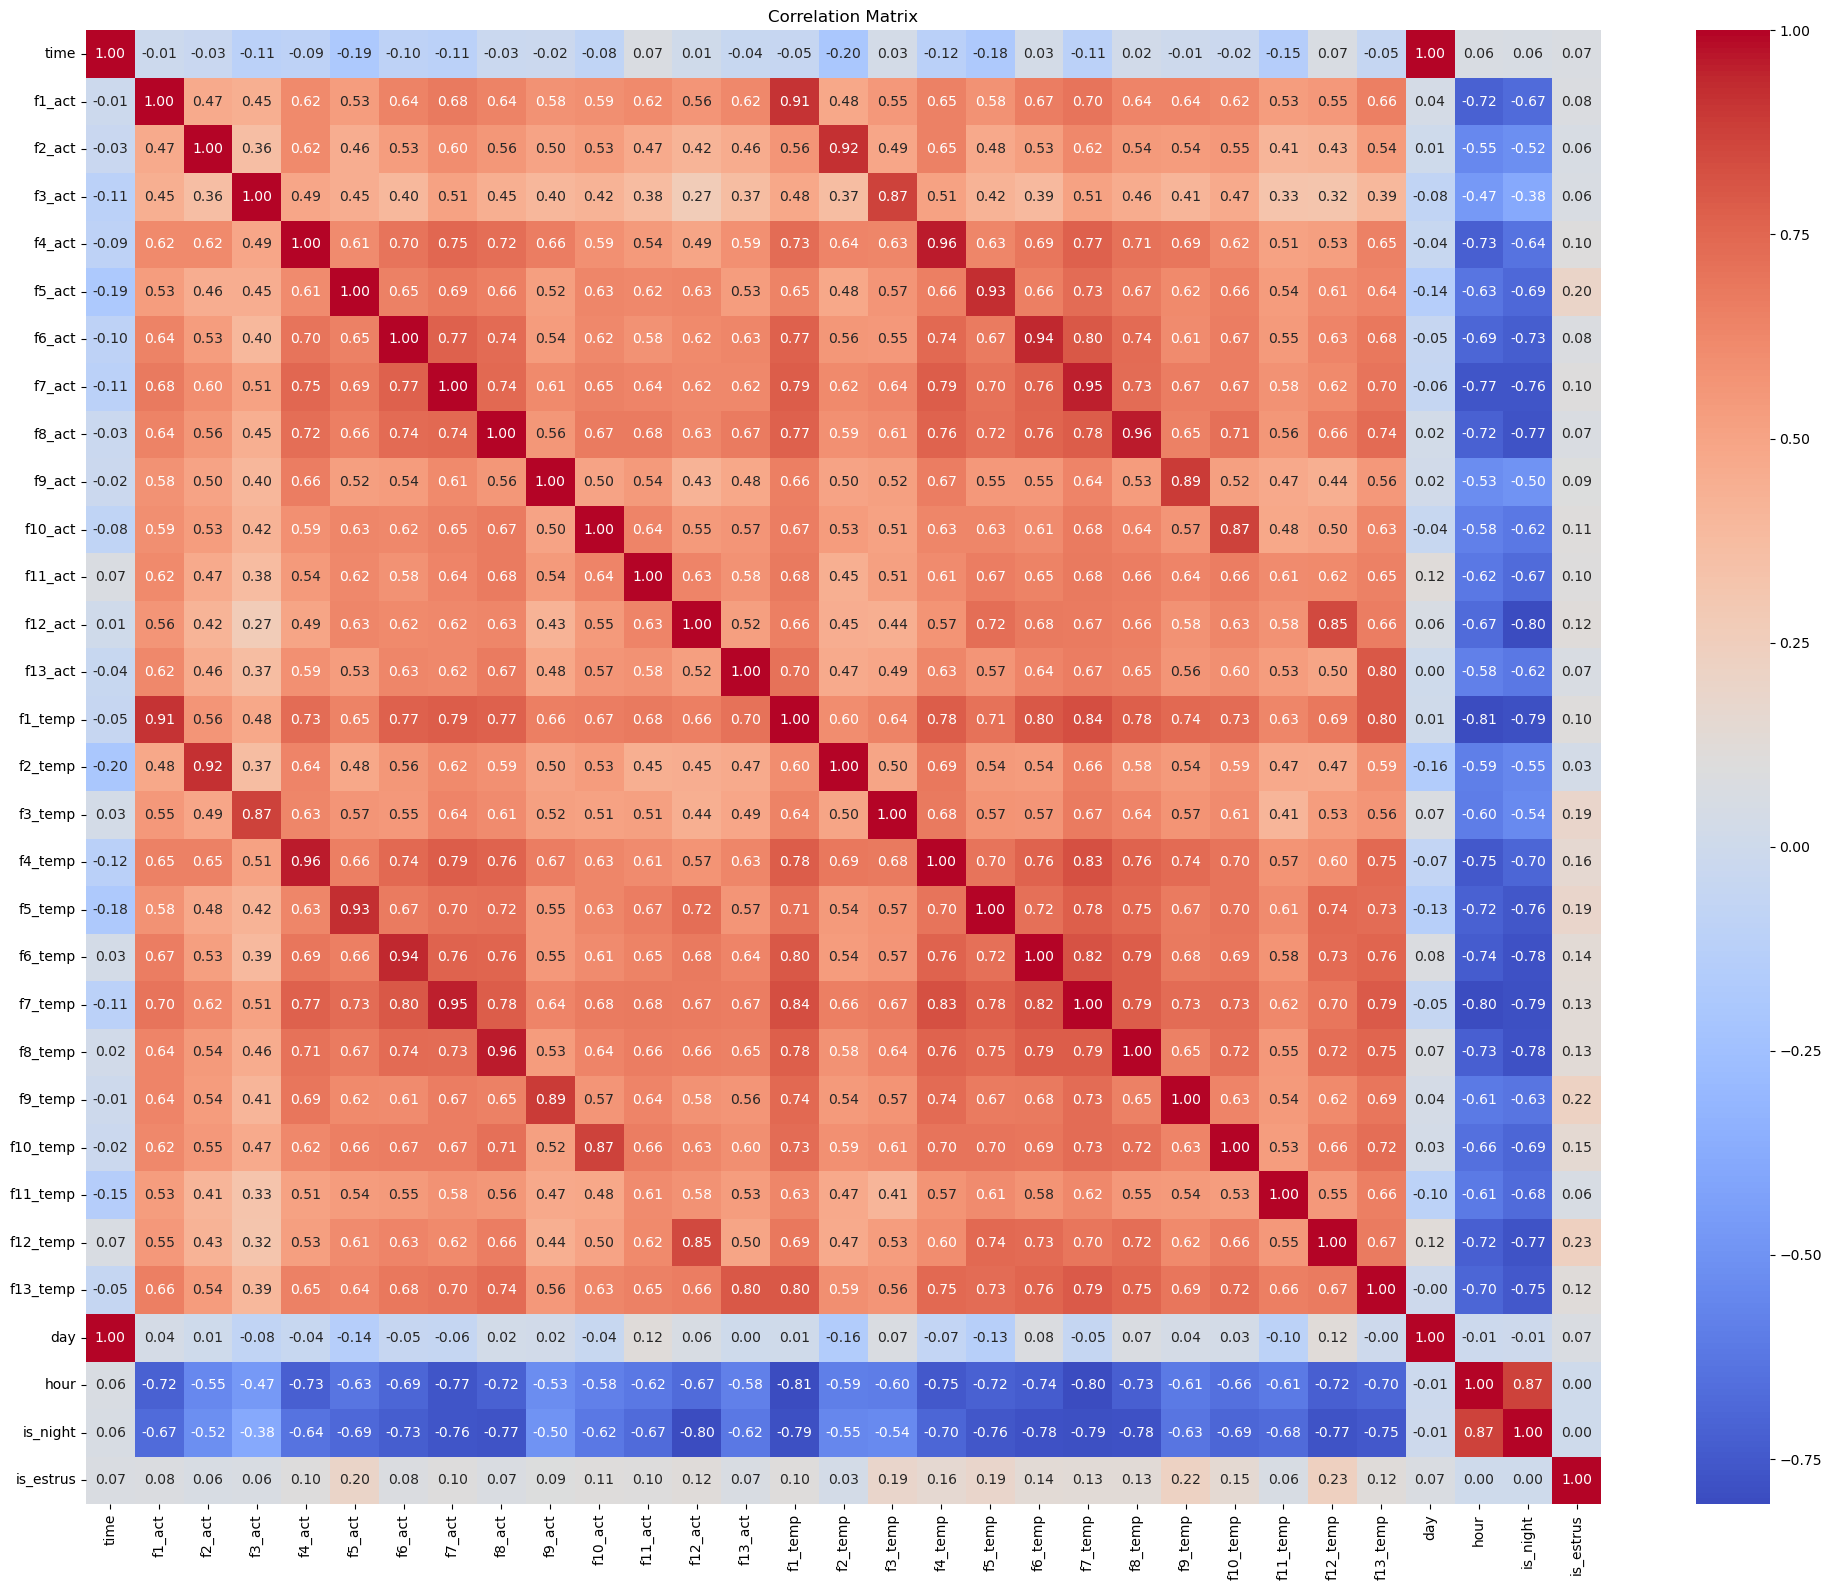

In [12]:
correlation_matrix = df_female.corr()
plt.figure(figsize=(20,16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [13]:
fig = go.Figure()

# Add each mouse's data as a separate line
for column in df_female.iloc[:,1:-17].columns:
    fig.add_trace(go.Scatter(x=df_female['time'], 
                            y=df_female[column],
                            name=column))

# Add rectangles for night and estrus periods
night_color = 'rgba(0, 0, 255, 0.3)'  # Blue for night
estrus_color = 'rgba(255, 0, 0, 0.5)' # Red for estrus

# Iterate through each row of the DataFrame
for i, row in df_female.iterrows():
    if row['is_night']:
        fig.add_shape(
            type="rect",
            x0=row['time'] - 0.5,
            x1=row['time'] + 0.5,
            y0=0,
            y1=1,
            fillcolor=night_color,
            opacity=0.2,
            line_width=0,
            xref='x',
            yref='y domain'
        )
    if row['is_estrus']:
        fig.add_shape(
            type="rect",
            x0=row['time'] - 0.5,
            x1=row['time'] + 0.5,
            y0=0,
            y1=1,
            fillcolor=estrus_color,
            opacity=0.2,
            line_width=0,
            xref='x',
            yref='y domain'
        )

# Update layout
fig.update_layout(
    title='Female Mouse Activity',
    xaxis_title='Time',
    yaxis_title='Activity',
    legend_title='Mouse ID',
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="left",
        x=1
    )
)

fig.show()

In [14]:
# group by the time of the day and take the mean
male_hourly = df_male.groupby(['hour']).mean()
female_hourly = df_female.groupby(['hour']).mean()

In [15]:
fig = go.Figure()

# Add each mouse's data as a separate line
for column in male_hourly.iloc[:,1:-16].columns:
    fig.add_trace(go.Scatter(x=male_hourly.index, 
                            y=male_hourly[column],
                            name=column))

# Update layout
fig.update_layout(
    title='Male Mouse Activity by Hour',
    xaxis_title='Hour',
    yaxis_title='Activity',
    legend_title='Mouse ID',
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="left",
        x=1
    )
)

fig.show()

In [16]:
fig = go.Figure()

# Add each mouse's data as a separate line
for column in female_hourly.iloc[:,1:-16].columns:
    fig.add_trace(go.Scatter(x=female_hourly.index, 
                            y=female_hourly[column],
                            name=column))

# Update layout
fig.update_layout(
    title='Female Mouse Activity by Hour',
    xaxis_title='Hour',
    yaxis_title='Activity',
    legend_title='Mouse ID',
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="left",
        x=1
    )
)

fig.show()

In [17]:
mouse_act_df.columns

Index(['time', 'm1_act', 'm2_act', 'm3_act', 'm4_act', 'm5_act', 'm6_act',
       'm7_act', 'm8_act', 'm9_act', 'm10_act', 'm11_act', 'm12_act',
       'm13_act', 'm1_temp', 'm2_temp', 'm3_temp', 'm4_temp', 'm5_temp',
       'm6_temp', 'm7_temp', 'm8_temp', 'm9_temp', 'm10_temp', 'm11_temp',
       'm12_temp', 'm13_temp', 'day', 'hour', 'is_night', 'is_estrus',
       'f1_act', 'f2_act', 'f3_act', 'f4_act', 'f5_act', 'f6_act', 'f7_act',
       'f8_act', 'f9_act', 'f10_act', 'f11_act', 'f12_act', 'f13_act',
       'f1_temp', 'f2_temp', 'f3_temp', 'f4_temp', 'f5_temp', 'f6_temp',
       'f7_temp', 'f8_temp', 'f9_temp', 'f10_temp', 'f11_temp', 'f12_temp',
       'f13_temp', 'estrus_night', 'estrus_night_False_False',
       'estrus_night_False_True', 'estrus_night_True_False',
       'estrus_night_True_True'],
      dtype='object')

In [18]:
all_male_act = mouse_act_df[['m1_act', 'm2_act', 'm3_act', 'm4_act', 'm5_act', 'm6_act',
              'm7_act', 'm8_act', 'm9_act', 'm10_act', 'm11_act', 'm12_act',
              'm13_act']].melt(var_name="ID", value_name="activity")
all_male_temp = mouse_act_df[['m1_temp', 'm2_temp', 'm3_temp', 'm4_temp', 'm5_temp',
       'm6_temp', 'm7_temp', 'm8_temp', 'm9_temp', 'm10_temp', 'm11_temp',
       'm12_temp', 'm13_temp']].melt(var_name="ID", value_name="temperature")
all_female_act = mouse_act_df[['f1_act', 'f2_act', 'f3_act', 'f4_act', 'f5_act', 'f6_act', 'f7_act',
       'f8_act', 'f9_act', 'f10_act', 'f11_act', 'f12_act', 'f13_act']].melt(var_name="ID", value_name="activity")
all_female_temp = mouse_act_df[['f1_temp', 'f2_temp', 'f3_temp', 'f4_temp', 'f5_temp', 'f6_temp',
       'f7_temp', 'f8_temp', 'f9_temp', 'f10_temp', 'f11_temp', 'f12_temp',
       'f13_temp']].melt(var_name="ID", value_name="temperature")

In [19]:
female_dict = dict()
female_dict[0] = px.scatter(df_female,x='f1_temp',y='f1_act',color='is_estrus')
figure_data = female_dict[0].data 
for i in range(1,13):
    female_dict[i] = px.scatter(df_female,x=f'f{i+1}_temp',y=f'f{i+1}_act',color='is_estrus')
    figure_data += female_dict[i].data 
fig = go.Figure(data = figure_data)
fig.show()

In [20]:
px.scatter(df_female,x='f1_temp',y='f1_act',color='is_estrus')

<Axes: >

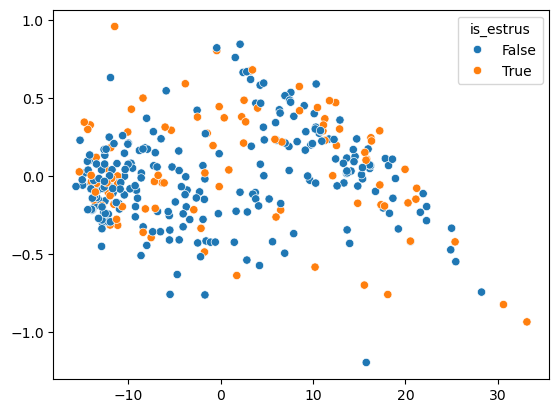

In [21]:
pca = PCA(n_components=2)
X = pca.fit_transform(mouse_act_df[['f1_temp','f1_act']].values)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=mouse_act_df['is_estrus'])

<Axes: >

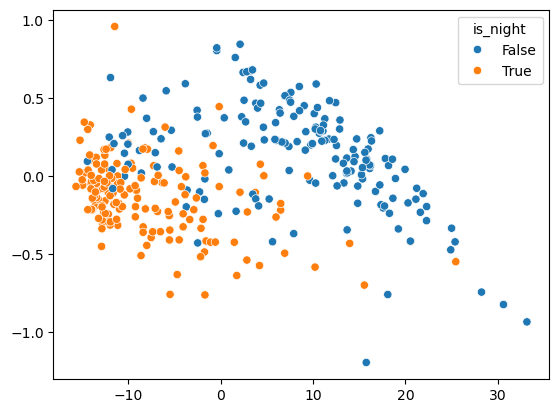

In [22]:
pca = PCA(n_components=2)
X = pca.fit_transform(mouse_act_df[['f1_temp','f1_act']].values)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=mouse_act_df['is_night'])

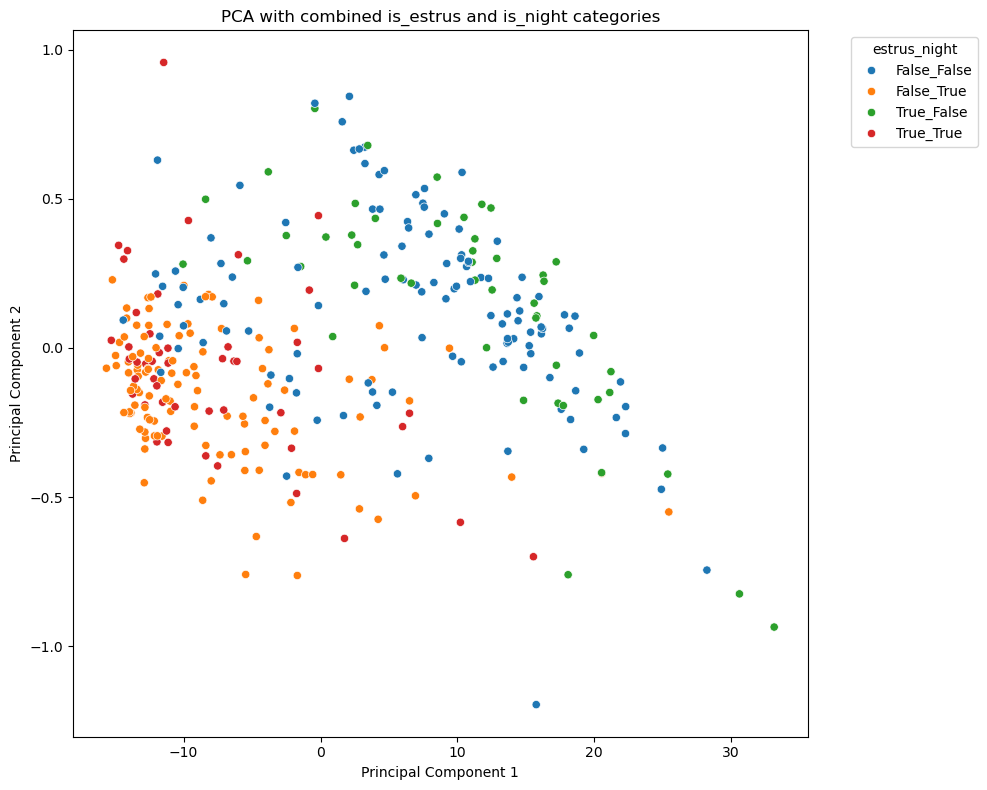

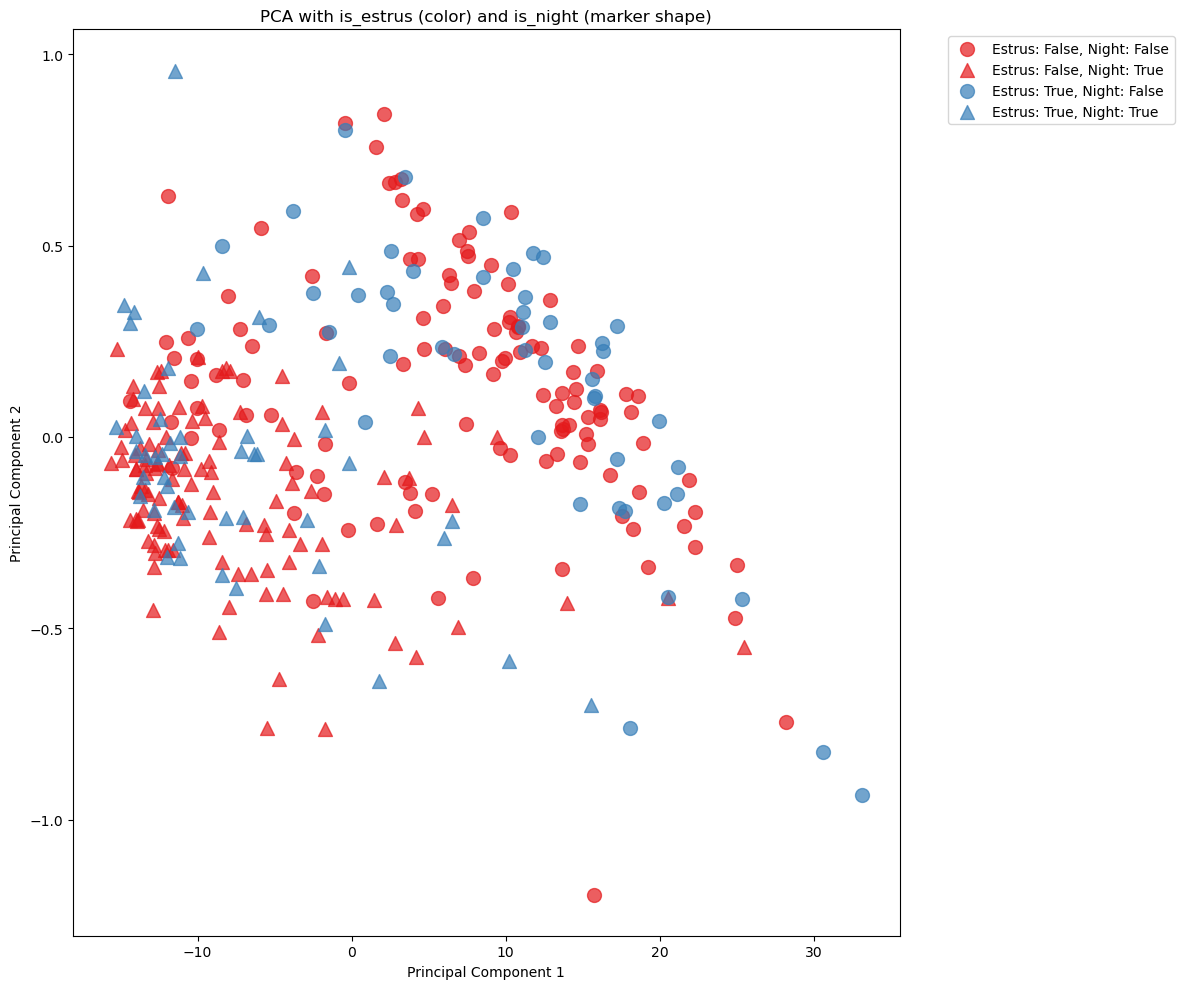

Explained variance ratio: [9.99253183e-01 7.46817387e-04]


In [23]:
# Create a figure with one subplot
plt.figure(figsize=(10, 8))

# Perform PCA
#cols = np.append(np.array(['f1_temp','f1_act']),ohe.get_feature_names_out())
pca = PCA(n_components=2)
X = pca.fit_transform(mouse_act_df[['f1_temp','f1_act']].values)

# Plot with the combined variable as hue
sns.scatterplot(x=X[:,0], y=X[:,1], hue=mouse_act_df['estrus_night'])
plt.title('PCA with combined is_estrus and is_night categories')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='estrus_night', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Approach 2: Use two plots with different markers and colors
plt.figure(figsize=(12, 10))

# Perform PCA
pca = PCA(n_components=2)
X = pca.fit_transform(mouse_act_df[['f1_temp', 'f1_act']].values)

# Create a custom plot where color represents is_estrus and marker style represents is_night
# First, get unique values for both variables
estrus_values = mouse_act_df['is_estrus'].unique()
night_values = mouse_act_df['is_night'].unique()

# Define color palette and markers
colors = sns.color_palette("Set1", len(estrus_values))
markers = ['o', '^', 's', 'D']  # Different marker shapes

# Plot each combination
for i, estrus_val in enumerate(estrus_values):
    for j, night_val in enumerate(night_values):
        mask = (mouse_act_df['is_estrus'] == estrus_val) & (mouse_act_df['is_night'] == night_val)
        plt.scatter(
            X[mask, 0], X[mask, 1], 
            color=colors[i], 
            marker=markers[j], 
            label=f'Estrus: {estrus_val}, Night: {night_val}',
            s=100,  # Size of markers
            alpha=0.7  # Transparency
        )

plt.title('PCA with is_estrus (color) and is_night (marker shape)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)


Logistic Regression - CV Accuracy: 0.7064
              precision    recall  f1-score   support

       False       0.74      0.97      0.84        62
        True       0.50      0.09      0.15        23

    accuracy                           0.73        85
   macro avg       0.62      0.53      0.49        85
weighted avg       0.68      0.73      0.65        85



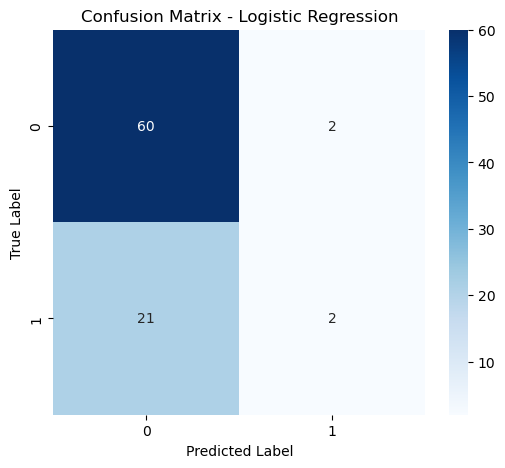


K-Nearest Neighbors - CV Accuracy: 0.6345
              precision    recall  f1-score   support

       False       0.74      0.89      0.81        62
        True       0.36      0.17      0.24        23

    accuracy                           0.69        85
   macro avg       0.55      0.53      0.52        85
weighted avg       0.64      0.69      0.65        85



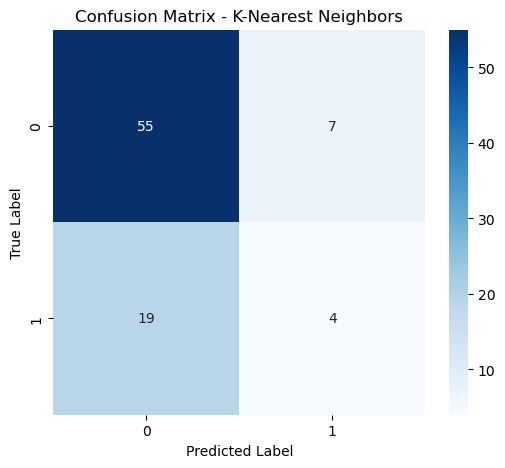


Decision Tree - CV Accuracy: 0.6505
              precision    recall  f1-score   support

       False       0.78      0.79      0.78        62
        True       0.41      0.39      0.40        23

    accuracy                           0.68        85
   macro avg       0.59      0.59      0.59        85
weighted avg       0.68      0.68      0.68        85



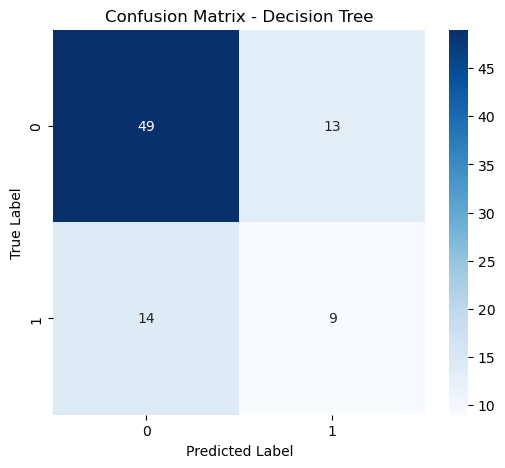


Random Forest - CV Accuracy: 0.6547
              precision    recall  f1-score   support

       False       0.76      0.84      0.80        62
        True       0.41      0.30      0.35        23

    accuracy                           0.69        85
   macro avg       0.59      0.57      0.57        85
weighted avg       0.67      0.69      0.68        85



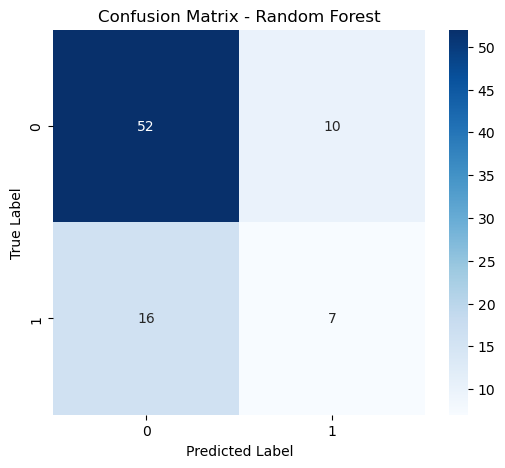


SVM - CV Accuracy: 0.7104
              precision    recall  f1-score   support

       False       0.73      1.00      0.84        62
        True       0.00      0.00      0.00        23

    accuracy                           0.73        85
   macro avg       0.36      0.50      0.42        85
weighted avg       0.53      0.73      0.62        85



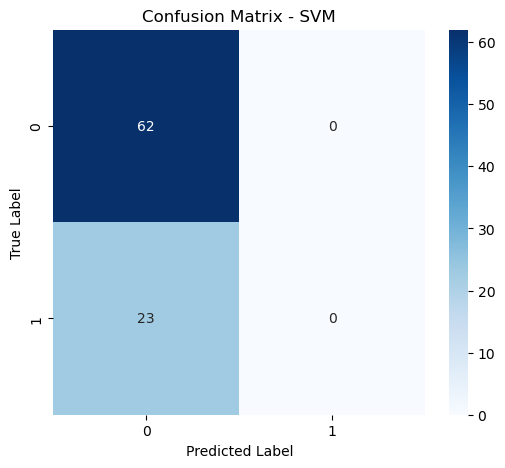


Gradient Boosting - CV Accuracy: 0.6585
              precision    recall  f1-score   support

       False       0.77      0.85      0.81        62
        True       0.44      0.30      0.36        23

    accuracy                           0.71        85
   macro avg       0.60      0.58      0.58        85
weighted avg       0.68      0.71      0.69        85



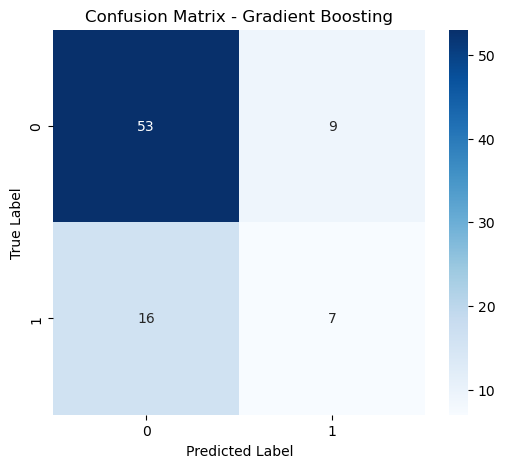


Neural Network - CV Accuracy: 0.7104
              precision    recall  f1-score   support

       False       0.73      0.98      0.84        62
        True       0.50      0.04      0.08        23

    accuracy                           0.73        85
   macro avg       0.62      0.51      0.46        85
weighted avg       0.67      0.73      0.64        85



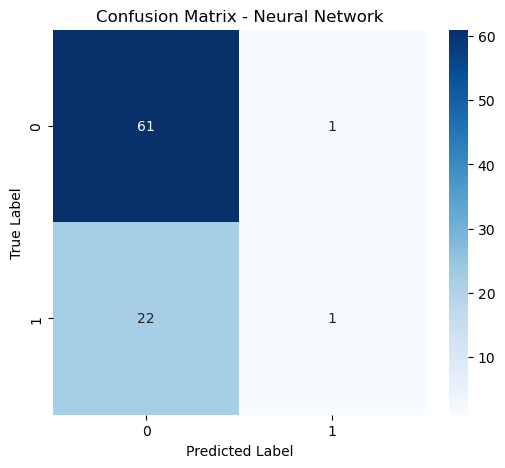

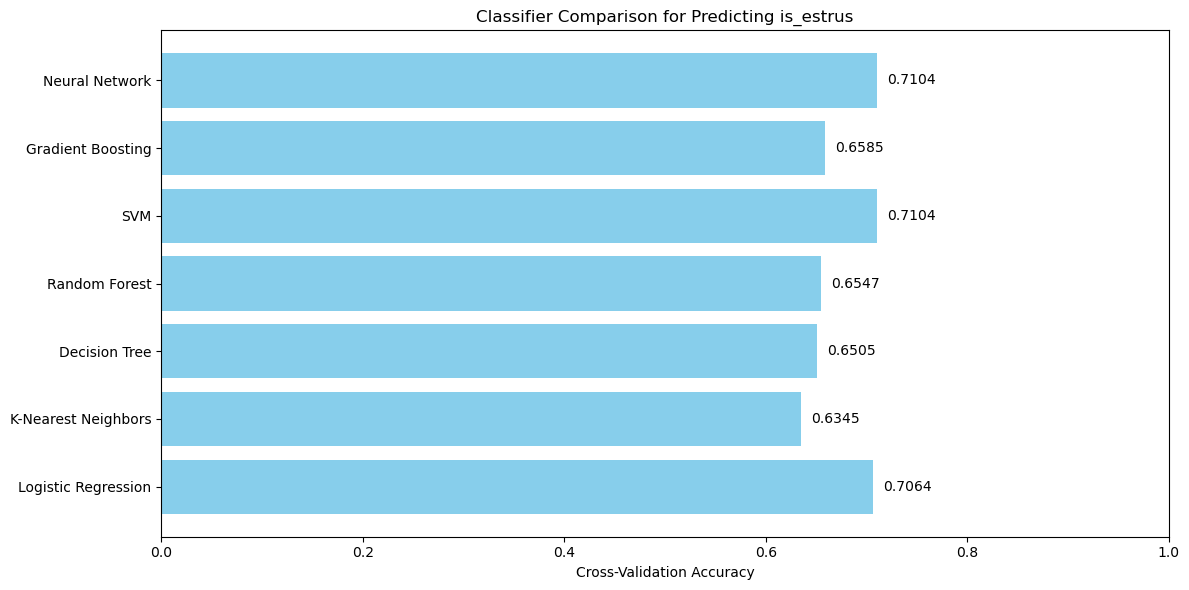

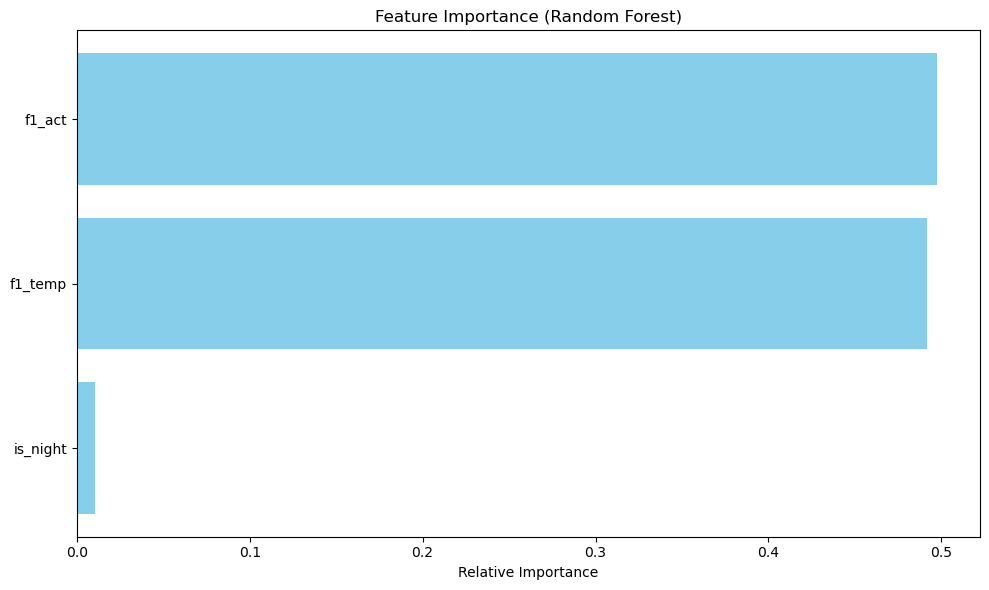

In [24]:
# Choose what to predict (is_estrus or is_night)
target = 'is_estrus'  # or 'is_night'

# Select features - using temperature and activity
features = ['f1_temp', 'f1_act']

# Add the other binary variable as a feature if desired
if target == 'is_estrus':
    features.append('is_night')
else:
    features.append('is_estrus')

# Prepare data
X = mouse_act_df[features]
y = mouse_act_df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Neural Network': MLPClassifier(max_iter=1000)
}

# Train and evaluate
results = {}
cv_scores = {}

for name, clf in classifiers.items():
    # Cross-validation
    scores = cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores[name] = scores.mean()
    
    # Train on full training set
    clf.fit(X_train_scaled, y_train)
    
    # Evaluate on test set
    y_pred = clf.predict(X_test_scaled)
    results[name] = {
        'accuracy': (y_pred == y_test).mean(),
        'report': classification_report(y_test, y_pred,zero_division=0, output_dict=True)
    }
    
    print(f"\n{name} - CV Accuracy: {scores.mean():.4f}")
    print(classification_report(y_test, y_pred,zero_division=0))
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Compare overall accuracy
plt.figure(figsize=(12, 6))
models = list(cv_scores.keys())
accuracies = list(cv_scores.values())

plt.barh(models, accuracies, color='skyblue')
plt.xlabel('Cross-Validation Accuracy')
plt.title(f'Classifier Comparison for Predicting {target}')
plt.xlim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(v + 0.01, i, f"{v:.4f}", va='center')
plt.tight_layout()
plt.show()

# Feature importance for applicable models
if 'Random Forest' in classifiers:
    plt.figure(figsize=(10, 6))
    importances = classifiers['Random Forest'].feature_importances_
    indices = np.argsort(importances)
    
    plt.barh(range(len(indices)), importances[indices], color='skyblue')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2782/1331735032.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2782/1331735032.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2782/1331735032.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2

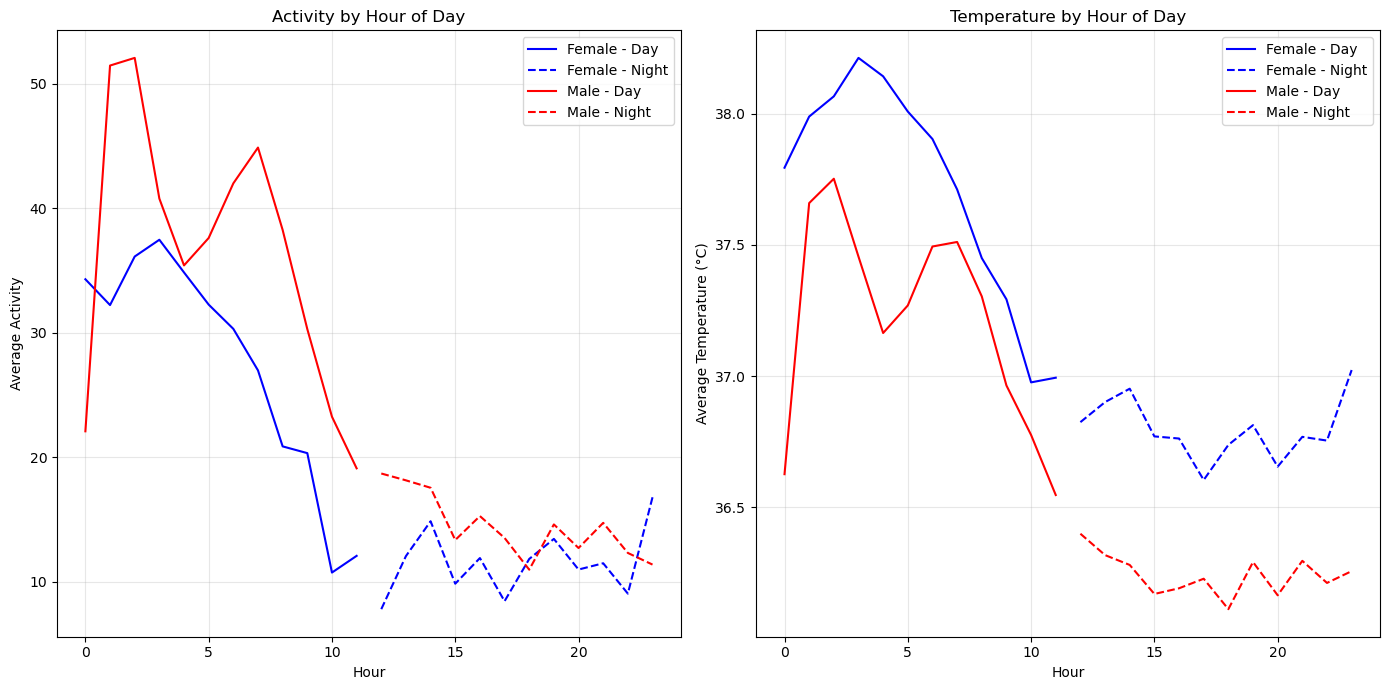

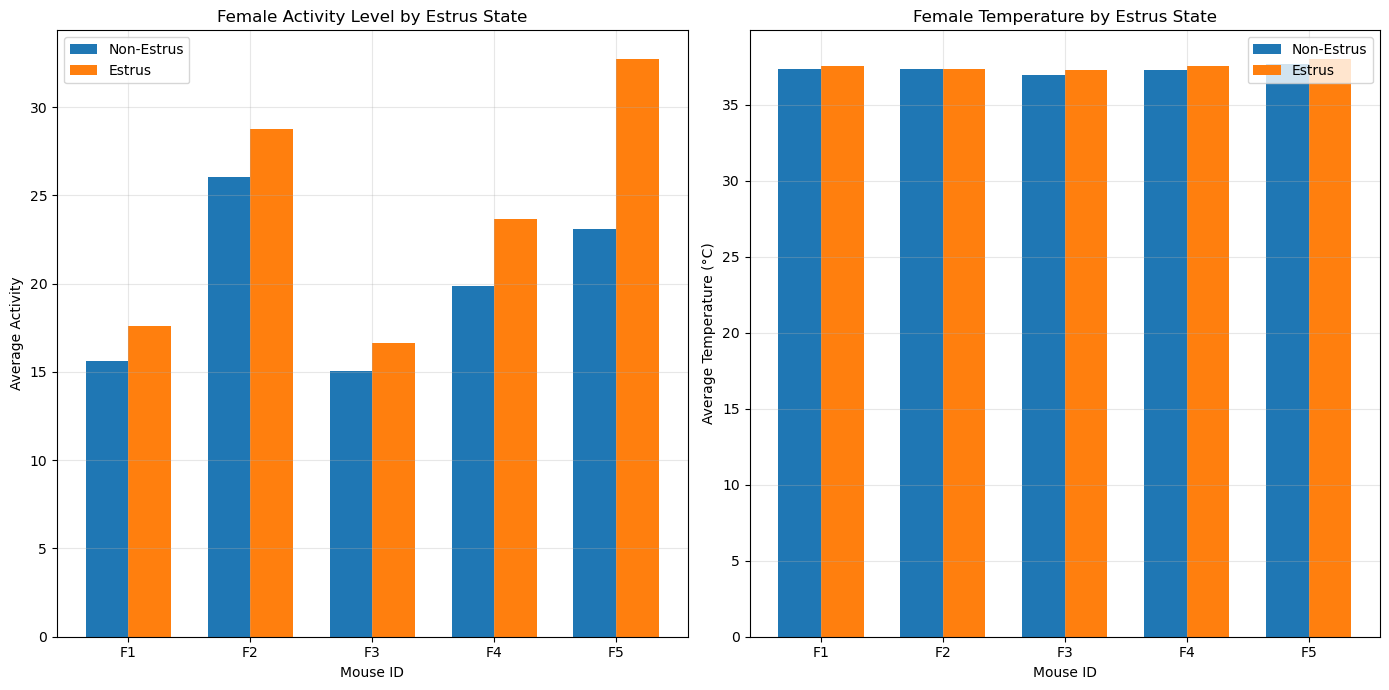

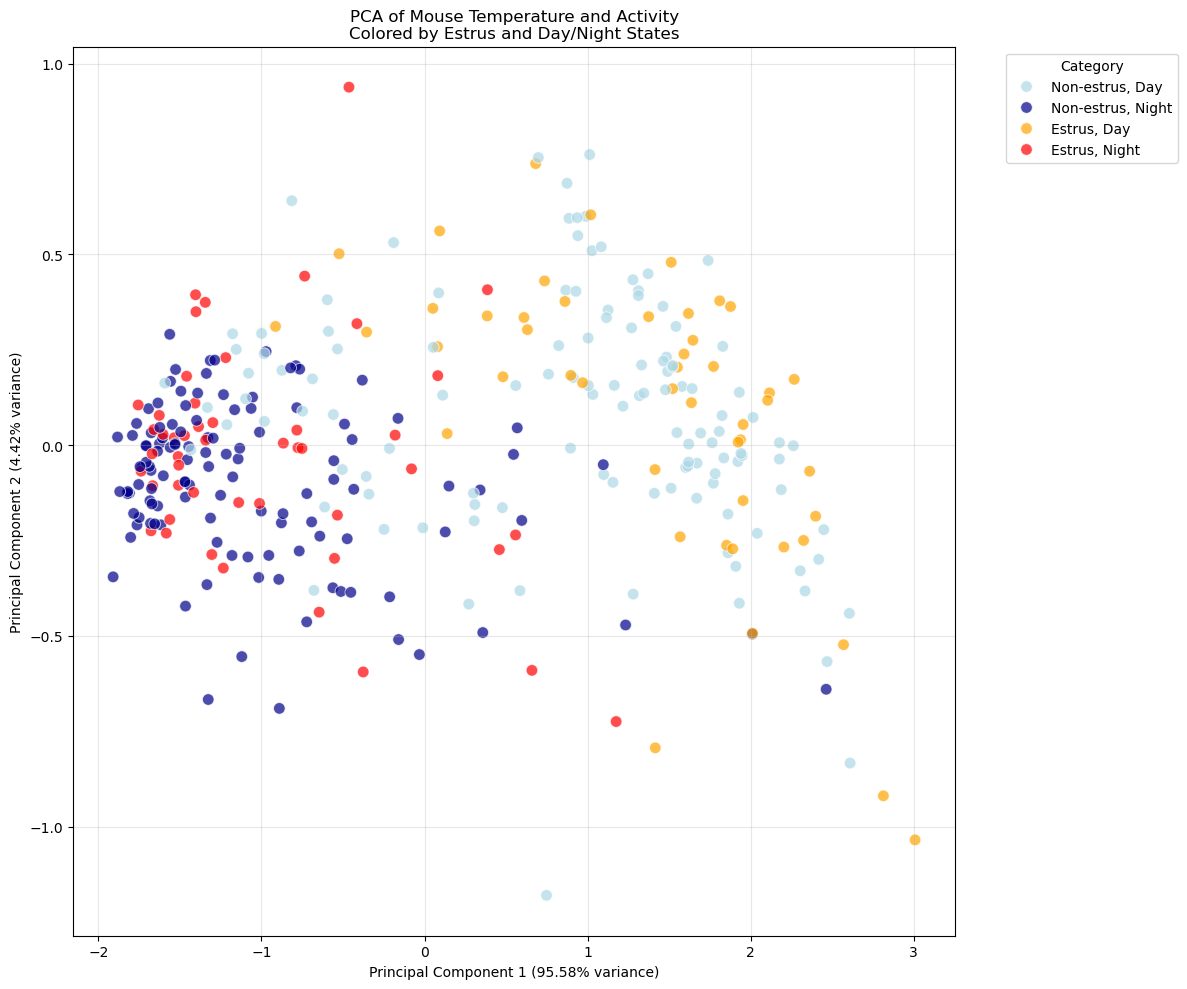

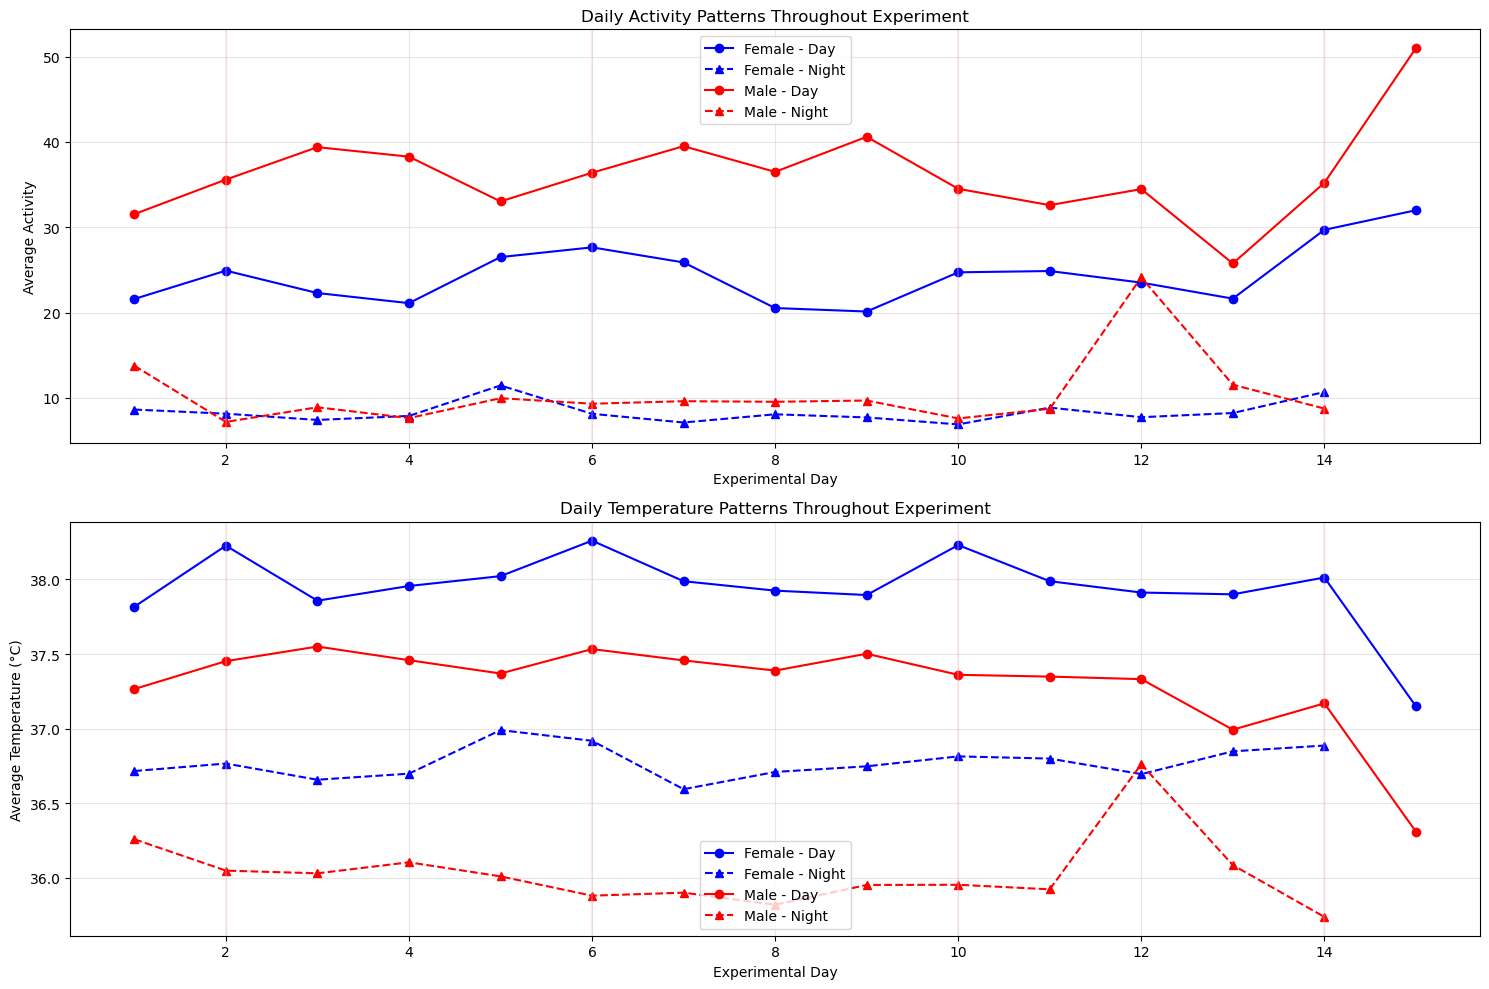

In [25]:
# 1. Time-based activity patterns (day vs night)
plt.figure(figsize=(14, 7))
# Create a time of day variable (assuming 'hour' is available)
# Group by hour and is_night
hourly_activity = mouse_act_df.groupby(['hour', 'is_night'])[['f1_act', 'f2_act', 'f3_act', 'm1_act', 'm2_act', 'm3_act']].mean()
hourly_activity = hourly_activity.reset_index()

# Plot female and male activity by hour, colored by night/day
plt.subplot(1, 2, 1)
day_data = hourly_activity[hourly_activity['is_night'] == 0]
night_data = hourly_activity[hourly_activity['is_night'] == 1]

# Calculate average female activity
day_data['female_avg'] = day_data[['f1_act', 'f2_act', 'f3_act']].mean(axis=1)
night_data['female_avg'] = night_data[['f1_act', 'f2_act', 'f3_act']].mean(axis=1)
day_data['male_avg'] = day_data[['m1_act', 'm2_act', 'm3_act']].mean(axis=1)
night_data['male_avg'] = night_data[['m1_act', 'm2_act', 'm3_act']].mean(axis=1)

plt.plot(day_data['hour'], day_data['female_avg'], 'b-', label='Female - Day')
plt.plot(night_data['hour'], night_data['female_avg'], 'b--', label='Female - Night')
plt.plot(day_data['hour'], day_data['male_avg'], 'r-', label='Male - Day')
plt.plot(night_data['hour'], night_data['male_avg'], 'r--', label='Male - Night')
plt.title('Activity by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Activity')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Temperature patterns over time
plt.subplot(1, 2, 2)
# Calculate average temperature for females and males during day vs night
temp_patterns = mouse_act_df.groupby(['hour', 'is_night'])[['f1_temp', 'f2_temp', 'f3_temp', 'm1_temp', 'm2_temp', 'm3_temp']].mean()
temp_patterns = temp_patterns.reset_index()

day_temp = temp_patterns[temp_patterns['is_night'] == 0]
night_temp = temp_patterns[temp_patterns['is_night'] == 1]

day_temp['female_temp_avg'] = day_temp[['f1_temp', 'f2_temp', 'f3_temp']].mean(axis=1)
night_temp['female_temp_avg'] = night_temp[['f1_temp', 'f2_temp', 'f3_temp']].mean(axis=1)
day_temp['male_temp_avg'] = day_temp[['m1_temp', 'm2_temp', 'm3_temp']].mean(axis=1)
night_temp['male_temp_avg'] = night_temp[['m1_temp', 'm2_temp', 'm3_temp']].mean(axis=1)

plt.plot(day_temp['hour'], day_temp['female_temp_avg'], 'b-', label='Female - Day')
plt.plot(night_temp['hour'], night_temp['female_temp_avg'], 'b--', label='Female - Night')
plt.plot(day_temp['hour'], day_temp['male_temp_avg'], 'r-', label='Male - Day')
plt.plot(night_temp['hour'], night_temp['male_temp_avg'], 'r--', label='Male - Night')
plt.title('Temperature by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('activity_temp_patterns.png', dpi=300)
plt.show()

# 3. Estrus effects on female activity and temperature
plt.figure(figsize=(14, 7))

# Activity during estrus vs non-estrus
plt.subplot(1, 2, 1)
# Filter for female mice
female_data = mouse_act_df[['is_estrus', 'f1_act', 'f2_act', 'f3_act', 'f4_act', 'f5_act']]
# Group by estrus state
estrus_activity = female_data.groupby('is_estrus')[[col for col in female_data.columns if col.endswith('_act')]].mean()

# Create a bar plot
activity_vals = estrus_activity.values.T  # Transpose to get mice as x-axis
x = np.arange(activity_vals.shape[0])
width = 0.35
plt.bar(x - width/2, activity_vals[:, 0], width, label='Non-Estrus')
plt.bar(x + width/2, activity_vals[:, 1], width, label='Estrus')
plt.title('Female Activity Level by Estrus State')
plt.xlabel('Mouse ID')
plt.ylabel('Average Activity')
plt.xticks(x, [f'F{i+1}' for i in range(activity_vals.shape[0])])
plt.legend()
plt.grid(True, alpha=0.3)

# Temperature during estrus vs non-estrus
plt.subplot(1, 2, 2)
female_temp = mouse_act_df[['is_estrus', 'f1_temp', 'f2_temp', 'f3_temp', 'f4_temp', 'f5_temp']]
estrus_temp = female_temp.groupby('is_estrus')[[col for col in female_temp.columns if col.endswith('_temp')]].mean()

# Create a bar plot
temp_vals = estrus_temp.values.T  # Transpose to get mice as x-axis
plt.bar(x - width/2, temp_vals[:, 0], width, label='Non-Estrus')
plt.bar(x + width/2, temp_vals[:, 1], width, label='Estrus')
plt.title('Female Temperature by Estrus State')
plt.xlabel('Mouse ID')
plt.ylabel('Average Temperature (°C)')
plt.xticks(x, [f'F{i+1}' for i in range(temp_vals.shape[0])])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('estrus_effects.png', dpi=300)
plt.show()

# 4. PCA visualization with both variables
plt.figure(figsize=(12, 10))

# Create a subset with main features
features_df = mouse_act_df[['f1_temp', 'f1_act', 'is_estrus', 'is_night']].dropna()

# Normalize data for PCA
X_features = features_df[['f1_temp', 'f1_act']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a combined categorical variable
features_df['category'] = features_df.apply(
    lambda row: f"{'Estrus' if row['is_estrus'] else 'Non-estrus'}, {'Night' if row['is_night'] else 'Day'}", 
    axis=1
)

# Create custom color mapping
palette = {
    "Estrus, Day": "orange",
    "Estrus, Night": "red", 
    "Non-estrus, Day": "lightblue",
    "Non-estrus, Night": "darkblue"
}

# Plot with the combined variable as hue
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=features_df['category'],
    palette=palette,
    s=70,
    alpha=0.7
)

plt.title('PCA of Mouse Temperature and Activity\nColored by Estrus and Day/Night States')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pca_visualization.png', dpi=300)
plt.show()

# 5. Daily rhythms over experimental days
plt.figure(figsize=(15, 10))

# Calculate daily averages for a representative female and male mouse
daily_avg = mouse_act_df.groupby(['day', 'is_night'])[['f1_act', 'f1_temp', 'm1_act', 'm1_temp']].mean().reset_index()

# Plot activity patterns
plt.subplot(2, 1, 1)
day_data = daily_avg[daily_avg['is_night'] == 0]
night_data = daily_avg[daily_avg['is_night'] == 1]

plt.plot(day_data['day'], day_data['f1_act'], 'bo-', label='Female - Day')
plt.plot(night_data['day'], night_data['f1_act'], 'b^--', label='Female - Night')
plt.plot(day_data['day'], day_data['m1_act'], 'ro-', label='Male - Day')
plt.plot(night_data['day'], night_data['m1_act'], 'r^--', label='Male - Night')

# Mark estrus days on the x-axis
estrus_days = list(range(2, 15, 4))
for day in estrus_days:
    plt.axvline(x=day, color='pink', linestyle='-', alpha=0.3)

plt.title('Daily Activity Patterns Throughout Experiment')
plt.xlabel('Experimental Day')
plt.ylabel('Average Activity')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot temperature patterns
plt.subplot(2, 1, 2)
plt.plot(day_data['day'], day_data['f1_temp'], 'bo-', label='Female - Day')
plt.plot(night_data['day'], night_data['f1_temp'], 'b^--', label='Female - Night')
plt.plot(day_data['day'], day_data['m1_temp'], 'ro-', label='Male - Day')
plt.plot(night_data['day'], night_data['m1_temp'], 'r^--', label='Male - Night')

# Mark estrus days on the x-axis
for day in estrus_days:
    plt.axvline(x=day, color='pink', linestyle='-', alpha=0.3)

plt.title('Daily Temperature Patterns Throughout Experiment')
plt.xlabel('Experimental Day')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('daily_patterns.png', dpi=300)
plt.show()